In [1]:
import os
from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from difflib import SequenceMatcher
import math
import re
from collections import Counter

# Load Data from Dump

In [2]:
TEXT_FILE_PATH = "./dumps/Tue Oct 04 00 41 42 2022_evaluation_result.txt"
SEPARATOR = " "
STEP_SIZE = 5
ASCII_CHAR_COUNT = 256
class CipherName(Enum):
    AES = "aes"
    RC4 = "rc4"
    DES = "des"

In [3]:
file = open(TEXT_FILE_PATH, "r")
lines = file.readlines()

In [4]:
class EvaluationResult:
    def __init__(
        self,
        cipherName,
        plainTextRaw,
        cipherTextRaw,
        encryptMean,
        encryptStdDev,
        decryptMean,
        decryptStdDev,
        nIter
    ):
        self.cipherName = cipherName
        
        self.encryptMean = encryptMean
        self.encryptStdDev = encryptStdDev
        
        self.decryptMean = decryptMean
        self.decryptStdDev = decryptStdDev
        
        self.nIter = nIter
        
        self.plainTextAsciiCodes = self.__convertRawToAsciiCodes(plainTextRaw)
        self.plainTextLength = len(self.plainTextAsciiCodes)
        self.plainTextAsciiCodeFreqMap = self.__createAsciiCodeFreqMap(self.plainTextAsciiCodes)
        self.plainText = self.__convertAsciiCodesToString(self.plainTextAsciiCodes)
        self.plainTextBinary = self.__convertStringToBinary(self.plainTextAsciiCodes)
        
        self.cipherTextAsciiCodes = self.__convertRawToAsciiCodes(cipherTextRaw)
        self.cipherTextLength = len(self.cipherTextAsciiCodes)
        self.cipherTextAsciiCodeFreqMap = self.__createAsciiCodeFreqMap(self.cipherTextAsciiCodes)
        self.cipherText = self.__convertAsciiCodesToString(self.cipherTextAsciiCodes)
        self.cipherTextBinary = self.__convertStringToBinary(self.cipherTextAsciiCodes)
    
    def __convertRawToAsciiCodes(self, text):
        tokens = text.split(SEPARATOR)
        result = []
        for token in tokens:
            result.append(int(token))
        return result
            
    def __createAsciiCodeFreqMap(self, asciiCodes):
        freqMap = [0] * ASCII_CHAR_COUNT
        for asciiCode in asciiCodes:
            freqMap[asciiCode] += 1
        return freqMap
    
    # ref: https://www.reddit.com/r/learnpython/comments/r1n6oh/how_do_i_print_extended_ascii_codes/
    def __convertAsciiCodesToString(self, asciiCodes):
        return bytes(asciiCodes).decode('cp437')
    
    # TODO: this one kinda sus
    def __convertStringToBinary(self, asciiCodes):
        result = ""
        for asciiCode in asciiCodes:
            result += "{0:b}".format(asciiCode)
        return result

In [5]:
data = {
    CipherName.AES.value: [],
    CipherName.RC4.value: [],
    CipherName.DES.value: []
}

for i in range(0, len(lines), STEP_SIZE):
    cipherName = lines[i].replace("\n", "")
    plainTextRaw = lines[i + 1].replace("\n", "")
    cipherTextRaw = lines[i + 2].replace("\n", "")
    
    encryptTime = lines[i + 3].replace("\n", "").split(SEPARATOR)
    encryptMean = float(encryptTime[0])
    encryptStdDev = float(encryptTime[1])
    
    decryptTime = lines[i + 4].replace("\n", "").split(SEPARATOR)
    decryptMean = float(decryptTime[0])
    decryptStdDev = float(decryptTime[1])
    
    # encryptTime[2] == decryptTime[2]
    nIter = int(float(encryptTime[2]))
    
    data[cipherName].append(EvaluationResult(
        cipherName,
        plainTextRaw,
        cipherTextRaw,
        encryptMean,
        encryptStdDev,
        decryptMean,
        decryptStdDev,
        nIter
    ))

# Plot ASCII Character Frequency

In [6]:
def plotAsciiCodeFreqMap(data, cipherName):
    if len(data[cipherName]) == 0:
        return
    
    colCount = 2
    rowCount = len(data[cipherName])
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 30))
    
    fig.suptitle(f"ASCII Character Frequency {cipherName}", fontsize=16)

    x = np.array(range(0, ASCII_CHAR_COUNT))
    
    for i in range(0, rowCount):
        ax[i, 0].plot(x, np.array(data[cipherName][i].plainTextAsciiCodeFreqMap))
        ax[i, 0].set_title(f"Plain Text ({data[cipherName][i].plainTextLength})")
        ax[i, 0].set_xlabel('ASCII Code')
        ax[i, 0].set_ylabel('Frequency')
        
        ax[i, 1].plot(x, np.array(data[cipherName][i].cipherTextAsciiCodeFreqMap))
        ax[i, 1].set_title(f"Cipher Text ({data[cipherName][i].cipherTextLength})")
        ax[i, 1].set_xlabel('ASCII Code')
        ax[i, 1].set_ylabel('Frequency')

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

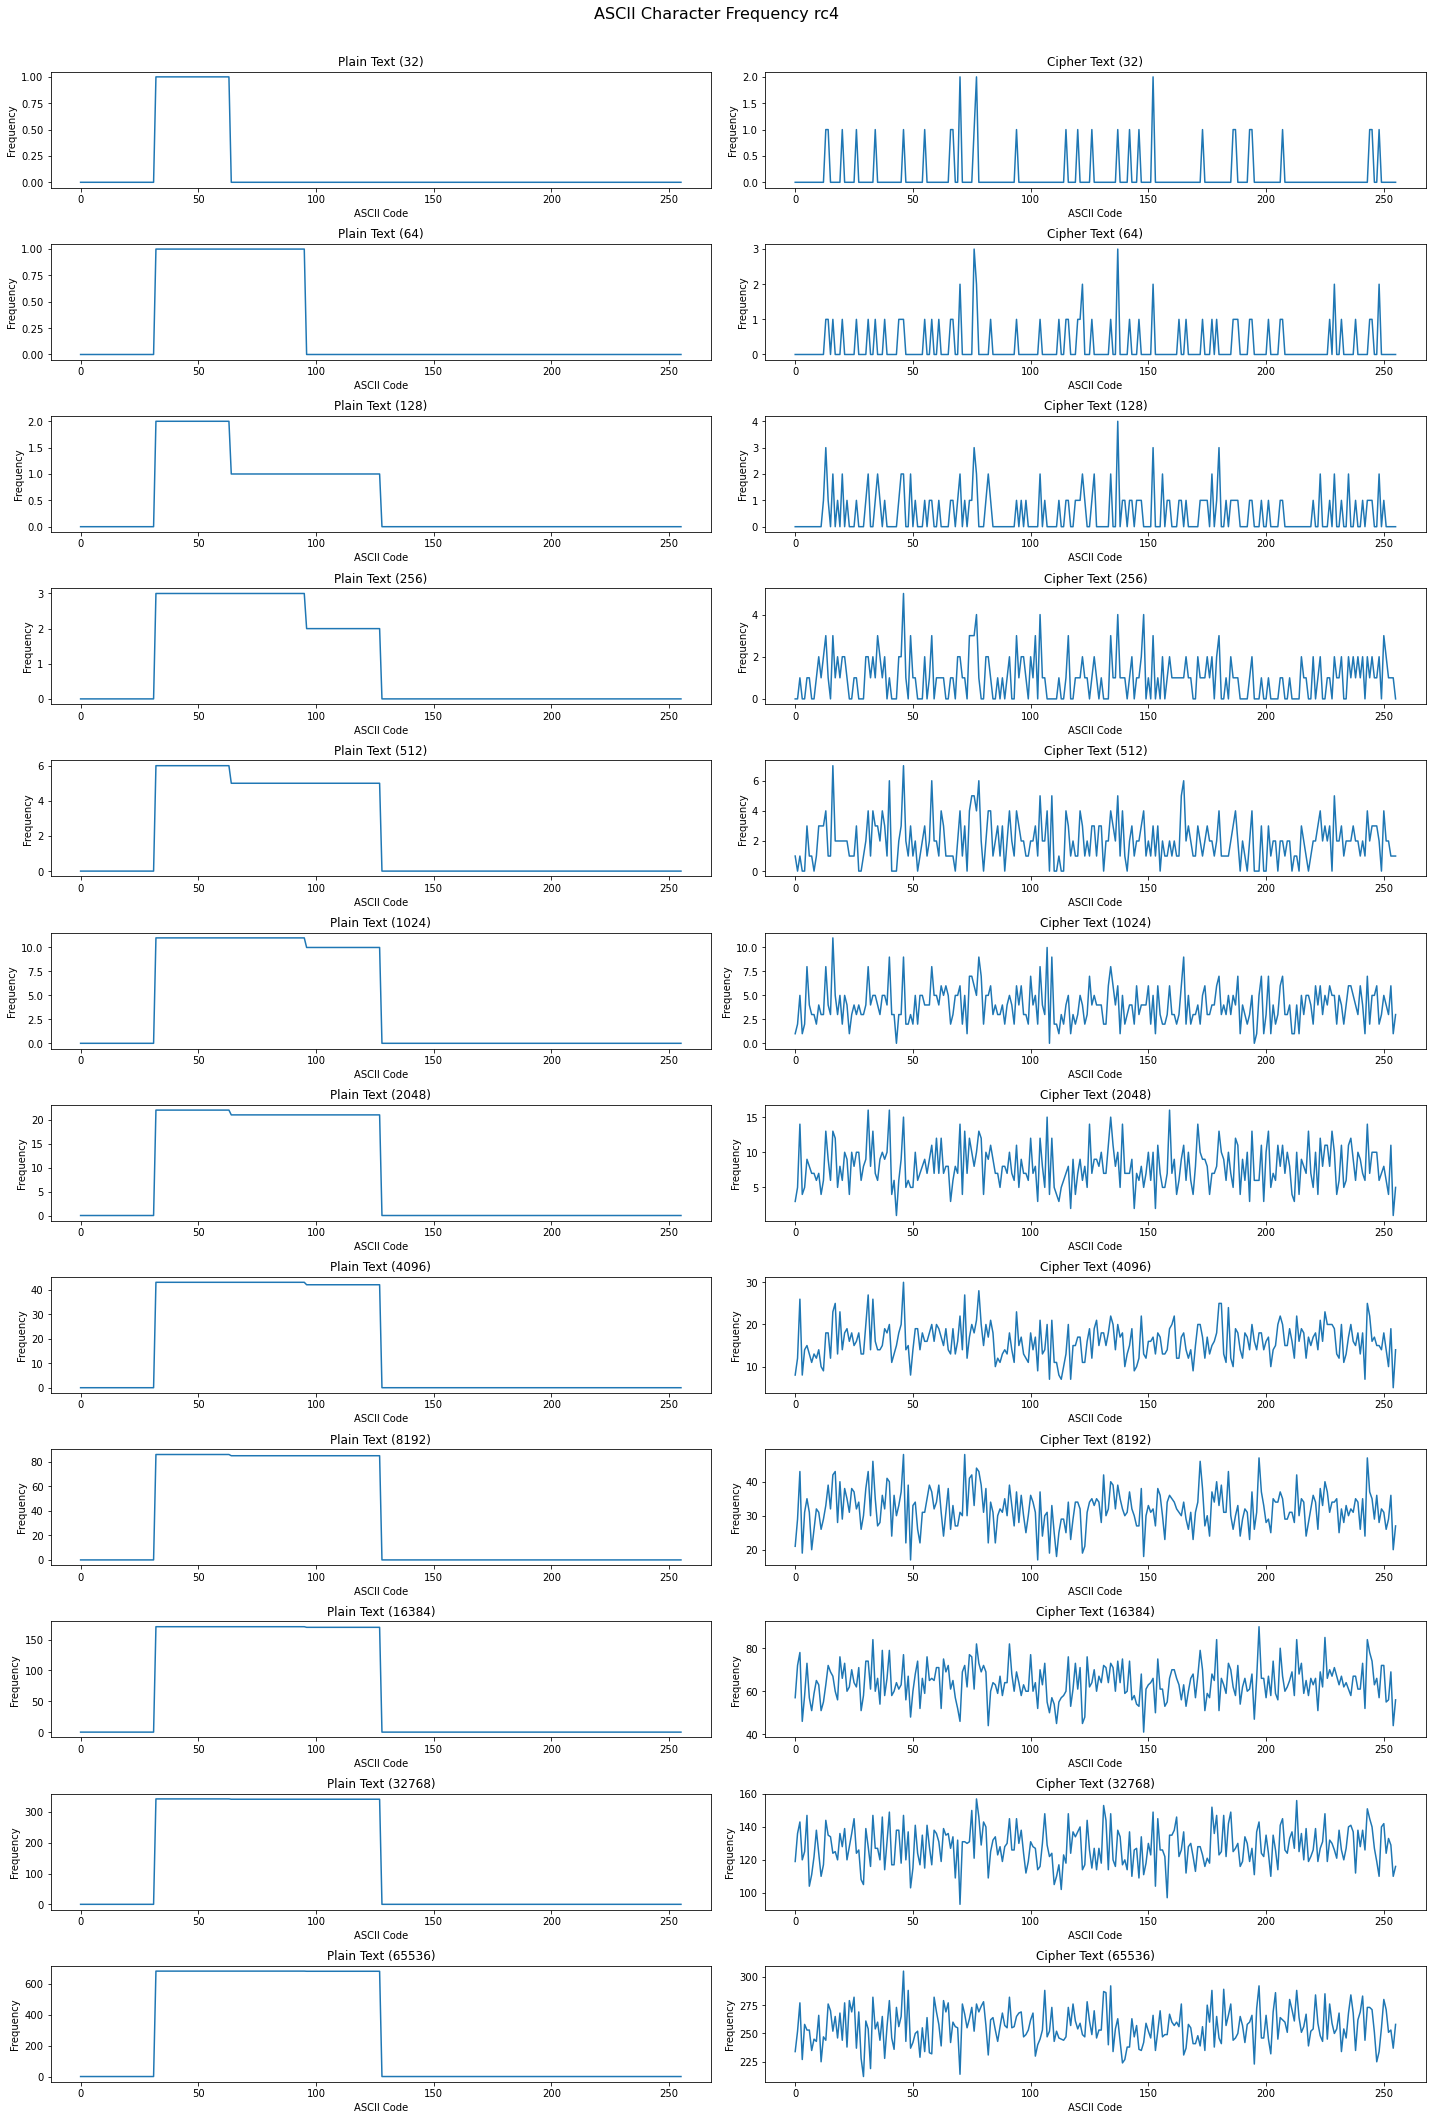

In [7]:
plotAsciiCodeFreqMap(data, CipherName.RC4.value)

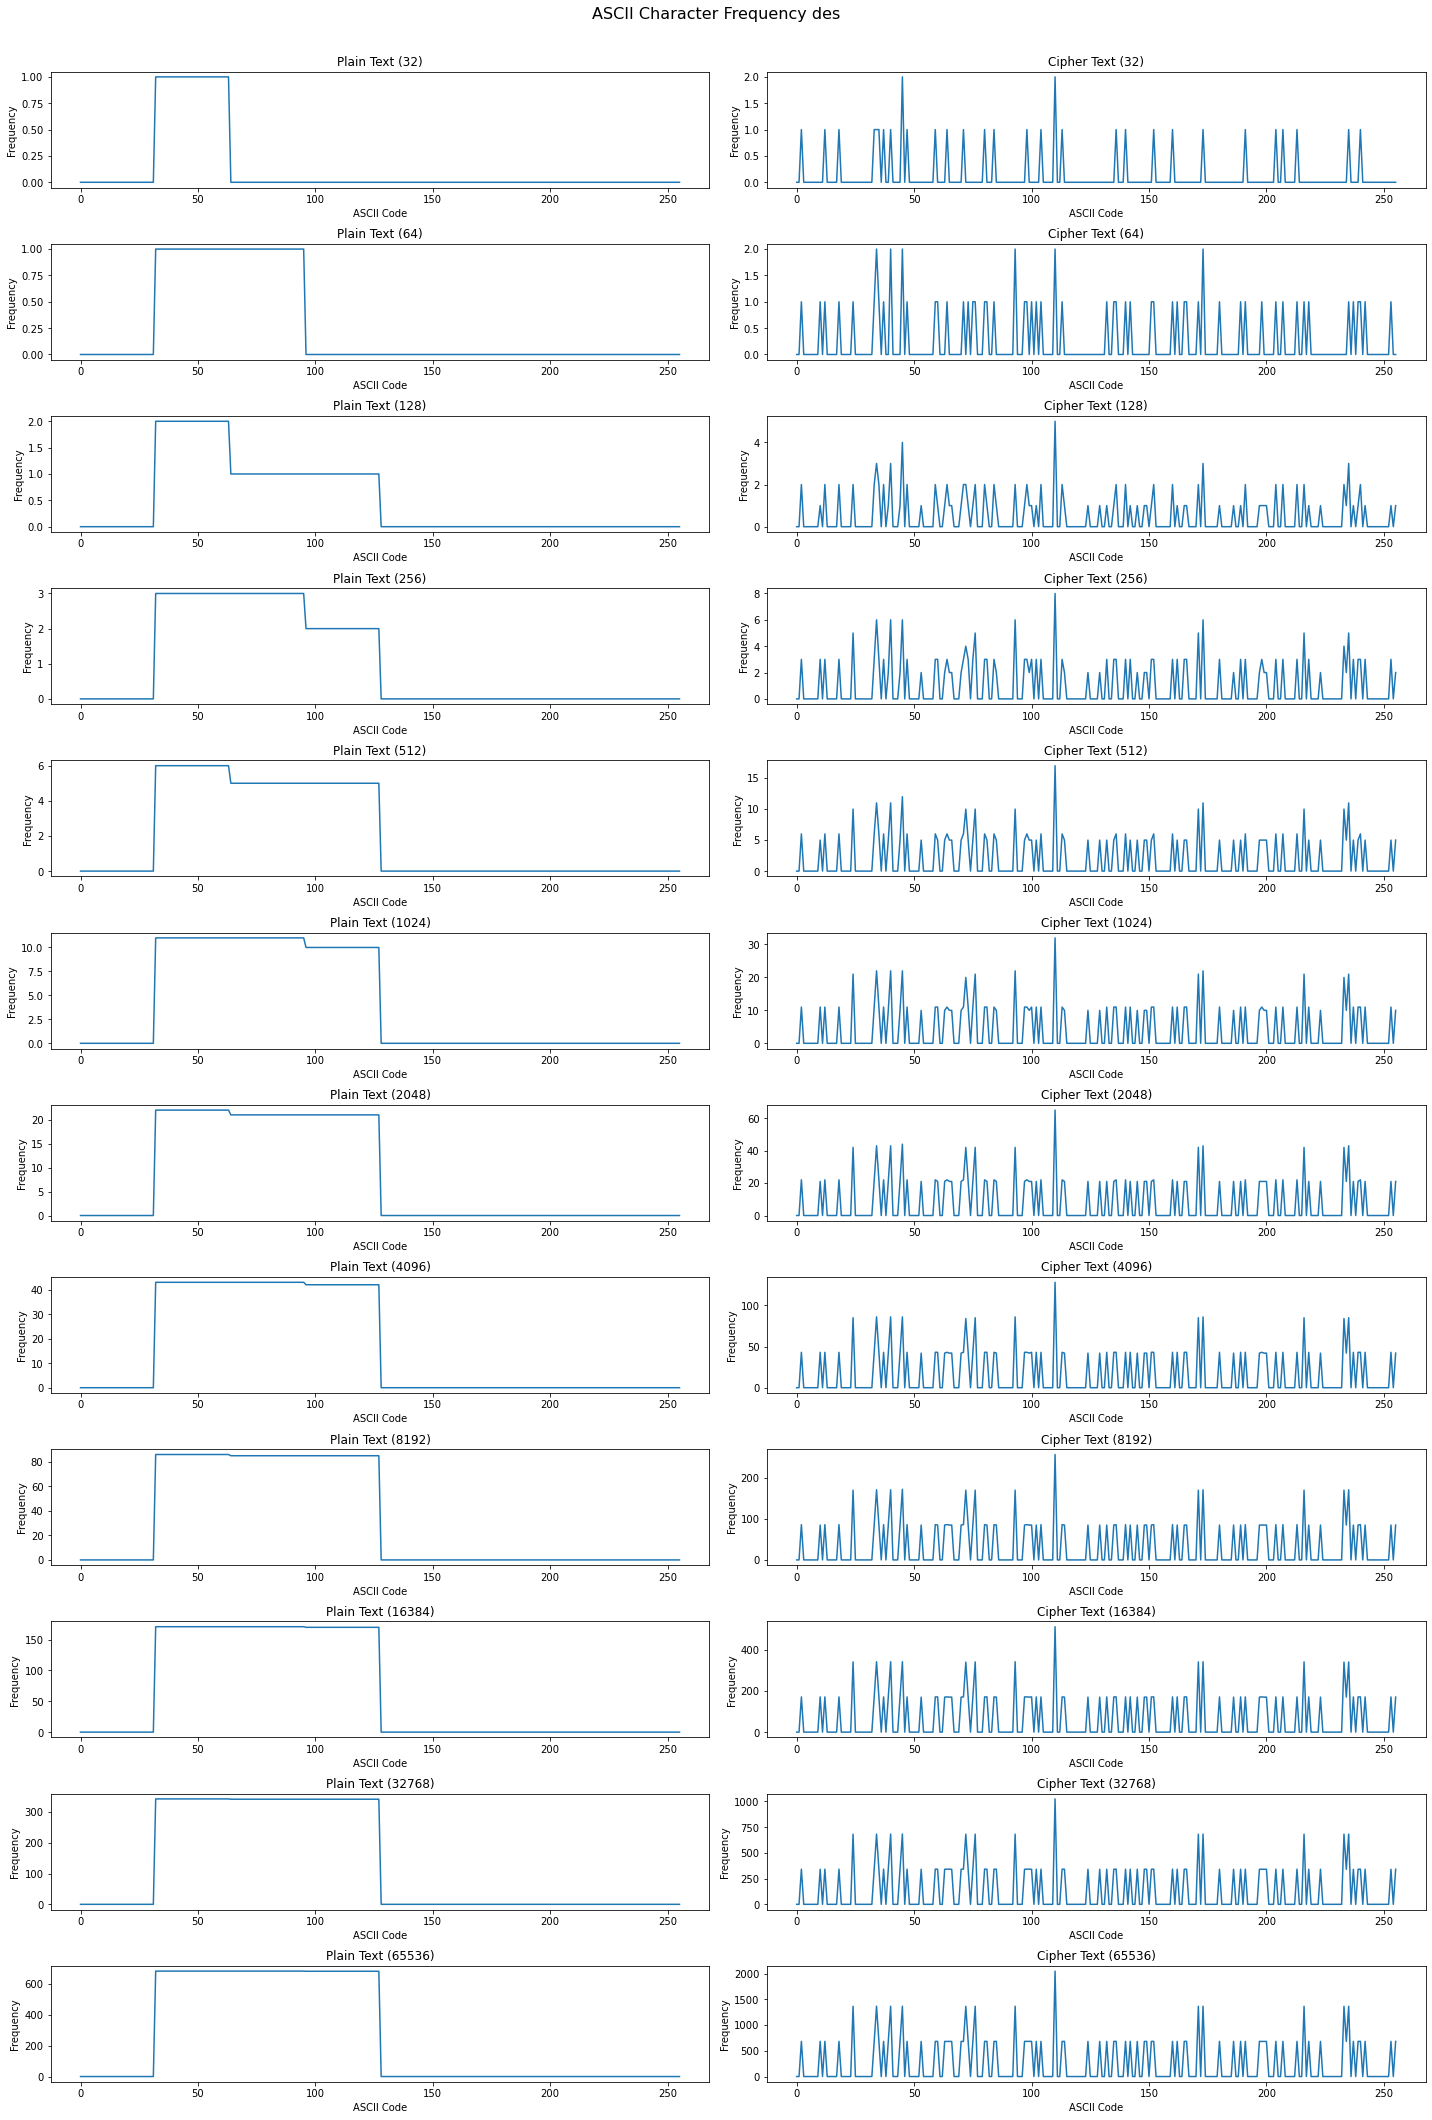

In [8]:
plotAsciiCodeFreqMap(data, CipherName.DES.value)

# Measure Plain Text and Cipher Text Similarities

In [9]:
def getSequenceMatcherRatio(a, b):
    return SequenceMatcher(None, a, b).ratio()

def getCosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def textToVector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)


def getCosineSimilarity(a, b):
    return getCosine(
        textToVector(a),
        textToVector(b)
    )

In [10]:
def measurePlainTextAndCipherTextSimilarities(cipherData):
    plainTextLengths = [i.plainTextLength for i in cipherData]
    cipherTextLengths = [i.cipherTextLength for i in cipherData]
    
    return pd.DataFrame(data={
        "plain text length": plainTextLengths,
        "cipher text length": cipherTextLengths,
        "sequence matcher": [getSequenceMatcherRatio(i.plainText, i.cipherText) for i in cipherData],
        "cosine similarity": [getCosineSimilarity(i.plainText, i.cipherText) for i in cipherData]
    })

In [11]:
measurePlainTextAndCipherTextSimilarities(data[CipherName.RC4.value])

,plain text length,cipher text length,sequence matcher,cosine similarity
0,32,32,0.031250,0.000000
1,64,64,0.046875,0.000000
2,128,128,0.046875,0.000000
3,256,256,0.011719,0.000000
4,512,512,0.017578,0.078285
5,1024,1024,0.010742,0.052108
6,2048,2048,0.013184,0.028642
7,4096,4096,0.007080,0.049052
8,8192,8192,0.005005,0.031321
9,16384,16384,0.002136,0.043653


In [12]:
measurePlainTextAndCipherTextSimilarities(data[CipherName.DES.value])

,plain text length,cipher text length,sequence matcher,cosine similarity
0,32,32,0.125000,0.0
1,64,64,0.078125,0.0
2,128,128,0.046875,0.0
3,256,256,0.031250,0.0
4,512,512,0.033203,0.0
5,1024,1024,0.021484,0.0
6,2048,2048,0.019531,0.0
7,4096,4096,0.000000,0.0
8,8192,8192,0.000000,0.0
9,16384,16384,0.000000,0.0


# Print Count of Zeros and Ones

In [13]:
def countOnes(text):
    count = 0
    for c in text:
        if c == "1":
            count += 1
    return count

def countZeroesAndOnesInPlainTextAndCipherText(cipherData):
    plainTextLengths = [i.plainTextLength for i in cipherData]
    cipherTextLengths = [i.cipherTextLength for i in cipherData]
    
    ptOneCounts = []
    ptZeroCounts = []
    ctOneCounts = []
    ctZeroCounts = []
    
    for i in range(0, len(cipherData)):
        ptOneCount = countOnes(cipherData[i].plainTextBinary)
        ptOneCounts.append(ptOneCount)
        
        ptZeroCount = abs(len(cipherData[i].plainTextBinary) - ptOneCount)
        ptZeroCounts.append(ptZeroCount)
        
        ctOneCount = countOnes(cipherData[i].cipherTextBinary)
        ctOneCounts.append(ctOneCount)
        
        ctZeroCount = abs(len(cipherData[i].cipherTextBinary) - ctOneCount)
        ctZeroCounts.append(ctZeroCount)
    
    return pd.DataFrame(data={
        "plain text length": plainTextLengths,
        "cipher text length": cipherTextLengths,
        
        "plain text total bits": [len(i.plainTextBinary) for i in cipherData],
        "cipher text total bits": [len(i.cipherTextBinary) for i in cipherData],
        
        "plain text 0s": ptZeroCounts,
        "plain text 1s": ptOneCounts,
        
        "cipher text 0s": ctZeroCounts,
        "cipher text 1s": ctOneCounts,
    })

In [14]:
countZeroesAndOnesInPlainTextAndCipherText(data[CipherName.RC4.value])

,plain text length,cipher text length,plain text total bits,cipher text total bits,plain text 0s,plain text 1s,cipher text 0s,cipher text 1s
0,32,32,192,225,80,112,101,124
1,64,64,416,456,192,224,202,254
2,128,128,832,905,352,480,393,512
3,256,256,1696,1794,736,960,775,1019
4,512,512,3392,3610,1440,1952,1538,2072
5,1024,1024,6816,7187,2912,3904,3057,4130
6,2048,2048,13632,14387,5792,7840,6180,8207
7,4096,4096,27296,28796,11616,15680,12419,16377
8,8192,8192,54592,57461,23200,31392,24828,32633
9,16384,16384,109216,114907,46432,62784,49357,65550


In [15]:
countZeroesAndOnesInPlainTextAndCipherText(data[CipherName.DES.value])

,plain text length,cipher text length,plain text total bits,cipher text total bits,plain text 0s,plain text 1s,cipher text 0s,cipher text 1s
0,32,32,192,216,80,112,104,112
1,64,64,416,450,192,224,209,241
2,128,128,832,900,352,480,418,482
3,256,256,1696,1818,736,960,837,981
4,512,512,3392,3636,1440,1952,1674,1962
5,1024,1024,6816,7290,2912,3904,3349,3941
6,2048,2048,13632,14580,5792,7840,6698,7882
7,4096,4096,27296,29178,11616,15680,13397,15781
8,8192,8192,54592,58356,23200,31392,26794,31562
9,16384,16384,109216,116730,46432,62784,53589,63141


# Plot Running Times Mean

In [16]:
def plotEncryptDecryptRunningTimesMean(data):
    # TODO: fix this because it assumes that plain text lenghts of AES, RC4, and DES are the same
    plainTextLengths = [i.plainTextLength for i in data[CipherName.RC4.value]]
    
    desEncrypt = [i.encryptMean for i in data[CipherName.DES.value]]
    rc4Encrypt = [i.encryptMean for i in data[CipherName.RC4.value]]
    
    desDecrypt = [i.decryptMean for i in data[CipherName.DES.value]]
    rc4Decrypt = [i.decryptMean for i in data[CipherName.RC4.value]]
    
    colCount = 2
    rowCount = 1
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 7))
    
    fig.suptitle(f"Running Times Mean", fontsize=16)

    ax[0].plot(plainTextLengths, np.array(desEncrypt), color='r', label=CipherName.DES.value)
    ax[0].plot(plainTextLengths, np.array(rc4Encrypt), color='g', label=CipherName.RC4.value)
    ax[0].set_title(f"Encrypt")
    ax[0].set_xlabel('Plain Text Length')
    ax[0].set_ylabel('Mean')
    ax[0].legend(loc="upper left")
    
    ax[1].plot(plainTextLengths, np.array(desDecrypt), color='r', label=CipherName.DES.value)
    ax[1].plot(plainTextLengths, np.array(rc4Decrypt), color='g', label=CipherName.RC4.value)
    ax[1].set_title(f"Decrypt")
    ax[1].set_xlabel('Plain Text Length')
    ax[1].set_ylabel('Mean')
    ax[1].legend(loc="upper left")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

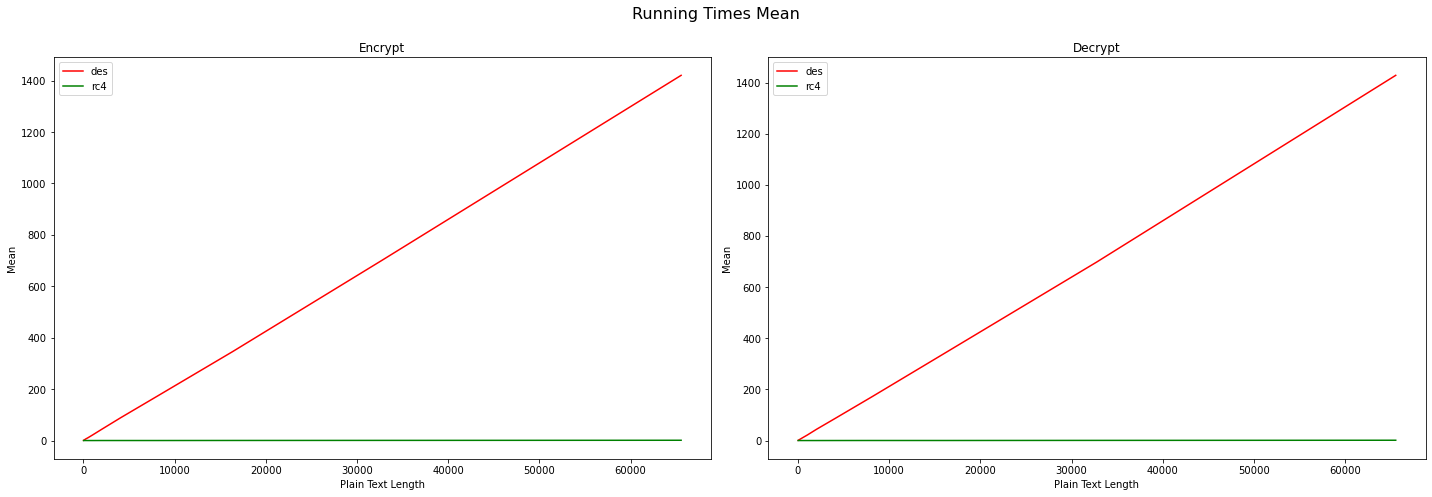

In [17]:
plotEncryptDecryptRunningTimesMean(data)

# Plot Running Times Population Standard Deviation

In [18]:
def plotEncryptDecryptRunningTimesPopStdDev(data):
    # TODO: fix this because it assumes that plain text lenghts of AES, RC4, and DES are the same
    plainTextLengths = [i.plainTextLength for i in data[CipherName.RC4.value]]
    
    desEncrypt = [i.encryptStdDev for i in data[CipherName.DES.value]]
    rc4Encrypt = [i.encryptStdDev for i in data[CipherName.RC4.value]]
    
    desDecrypt = [i.decryptStdDev for i in data[CipherName.DES.value]]
    rc4Decrypt = [i.decryptStdDev for i in data[CipherName.RC4.value]]
    
    colCount = 2
    rowCount = 1
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 7))
    
    fig.suptitle(f"Running Times Population Standard Deviation", fontsize=16)

    ax[0].plot(plainTextLengths, np.array(desEncrypt), color='r', label=CipherName.DES.value)
    ax[0].plot(plainTextLengths, np.array(rc4Encrypt), color='g', label=CipherName.RC4.value)
    ax[0].set_title(f"Encrypt")
    ax[0].set_xlabel('Plain Text Length')
    ax[0].set_ylabel('Population Standard Deviation')
    ax[0].legend(loc="upper left")
    
    ax[1].plot(plainTextLengths, np.array(desDecrypt), color='r', label=CipherName.DES.value)
    ax[1].plot(plainTextLengths, np.array(rc4Decrypt), color='g', label=CipherName.RC4.value)
    ax[1].set_title(f"Decrypt")
    ax[1].set_xlabel('Plain Text Length')
    ax[1].set_ylabel('Population Standard Deviation')
    ax[1].legend(loc="upper left")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

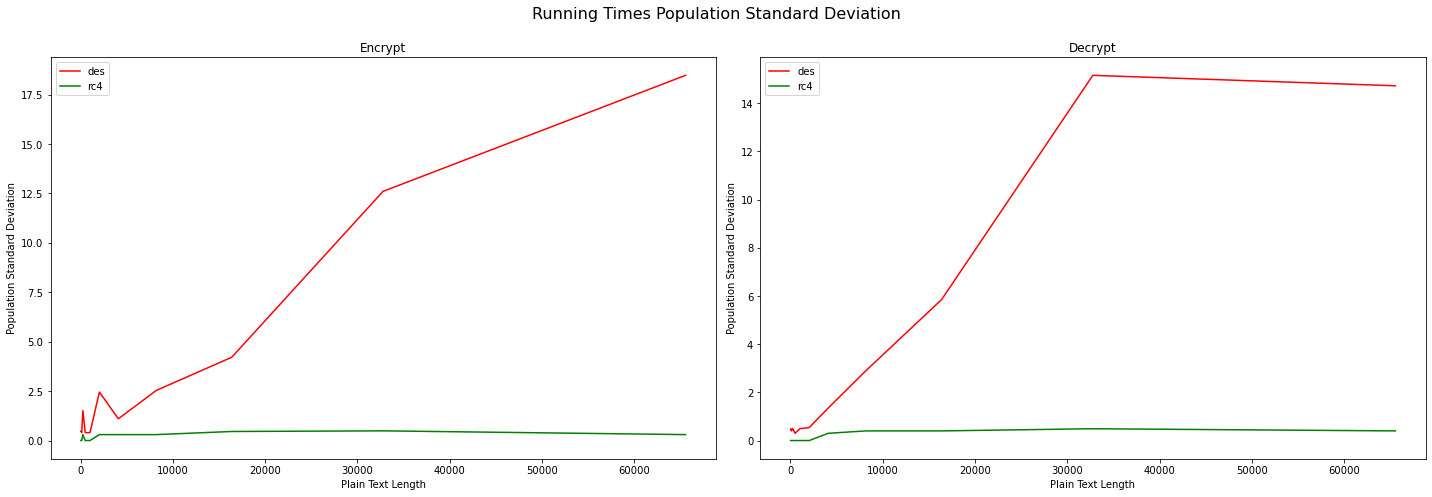

In [19]:
plotEncryptDecryptRunningTimesPopStdDev(data)

# Conclusion

RC4 is

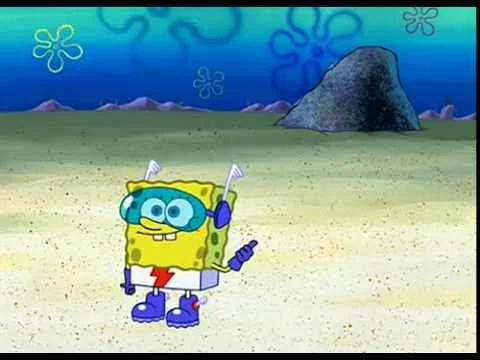